# Iris Species Preliminary Analysis

In [ ]:
! pip install opendp

   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/22.3 MB 13.8 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/22.3 MB 13.3 MB/s eta 0:00:02
   -------------- ------------------------- 8.1/22.3 MB 14.0 MB/s eta 0:00:02
   -------------------- ------------------- 11.5/22.3 MB 14.4 MB/s eta 0:00:01
   ------------------------ --------------- 13.6/22.3 MB 14.3 MB/s eta 0:00:01
   ------------------------------ --------- 17.0/22.3 MB 13.9 MB/s eta 0:00:01
   ------------------------------------ --- 20.2/22.3 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 22.3/22.3 MB 13.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opendp.mod import enable_features
from opendp.measurements import make_laplace
from opendp.domains import atom_domain
from opendp.metrics import absolute_distance
enable_features("contrib")

In [12]:
df_iris = pd.read_csv('../data/Iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [17]:
# Selecting values for epsilon
# Low ε (e.g., 0.1, 0.5) → More noise, stronger privacy, but lower accuracy.
# High ε (e.g., 5, 10) → Less noise, higher accuracy, but weaker privacy.

sepal_width = df_iris["SepalWidthCm"].to_numpy()
delta_1 = np.max(np.abs(np.diff(np.sort(sepal_width))))  

epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results = {}

In [18]:
for epsilon in epsilon_values:
    scale = delta_1 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    
    dp_sepal_width = np.array([laplace_mechanism(x) for x in sepal_width])
    mae = np.mean(np.abs(dp_sepal_width - sepal_width))
    results[epsilon] = {"dp_values": dp_sepal_width, "mae": mae}

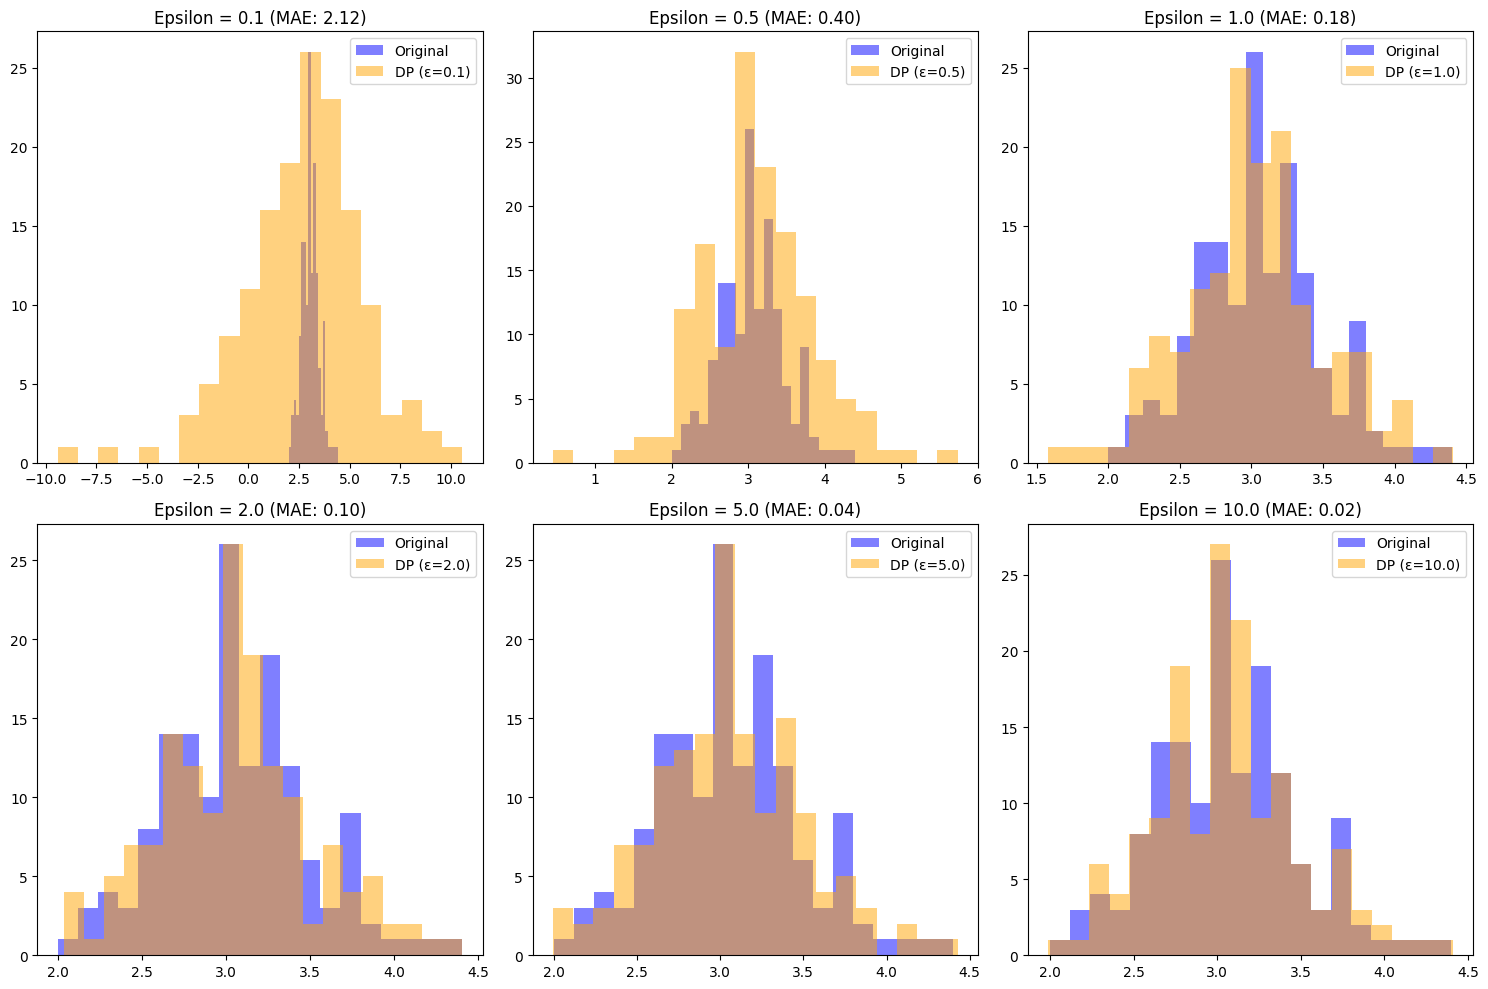

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (epsilon, data) in enumerate(results.items()):
    ax = axes[i]
    ax.hist(sepal_width, bins=20, alpha=0.5, label="Original", color='blue')
    ax.hist(data["dp_values"], bins=20, alpha=0.5, label=f"DP (ε={epsilon})", color='orange')
    ax.set_title(f"Epsilon = {epsilon} (MAE: {data['mae']:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# metric to measure accuracy
for epsilon, data in results.items():
    print(f"Epsilon: {epsilon}, Mean Absolute Error: {data['mae']:.3f}")

Epsilon: 0.1, Mean Absolute Error: 2.117
Epsilon: 0.5, Mean Absolute Error: 0.396
Epsilon: 1.0, Mean Absolute Error: 0.176
Epsilon: 2.0, Mean Absolute Error: 0.100
Epsilon: 5.0, Mean Absolute Error: 0.038
Epsilon: 10.0, Mean Absolute Error: 0.022
